In [6]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

import functools
from work.ws_paper.multilayer.matlab_code import multilayer
from work.ws_paper.multilayer import utils

In [7]:
# Define physical parameters for the fiber Bragg grating
num_layers = 10

n_1 = 1.45
n_2 = 1.48
n_section = [n_1, n_2]
n = [1.0] + num_layers * n_section + [1.0]

L_layer = 1e-3
L_section = [L_layer, L_layer]
L = [0.0] + num_layers * L_section + [0.0]

In [8]:
# S matrix function (and inverse)
get_S = functools.partial(multilayer.get_S, n=n, L=L)
get_S_inv = functools.partial(multilayer.get_S_inv, n=n, L=L)

In [9]:
# Sweep to look for poles
Dlam = 2.5e-10
lam_centre = 550e-9
lam_min = lam_centre - Dlam
lam_max = lam_centre + Dlam

k0_min = 2 * np.pi / lam_max - 400j
k0_max = 2 * np.pi / lam_min + 0j
num_points = 1 * 10**3

x, y, data = utils.sweep(k0_min, k0_max, num_points, get_S_inv)

  0%|          | 0/1000 [00:00<?, ?it/s]

TypeError: cannot unpack non-iterable NoneType object

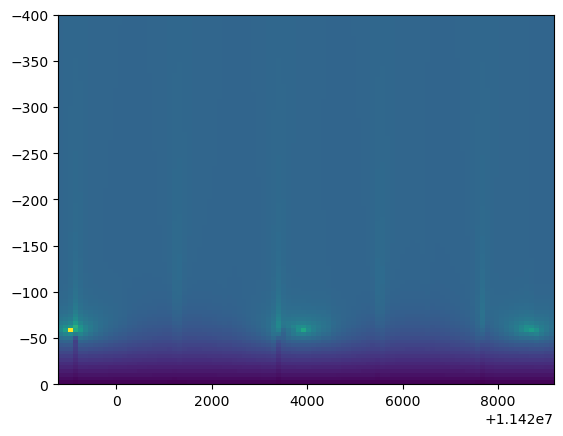

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(
    -np.log(data),
    extent=(k0_min.real, k0_max.real, 0.0, -400),
    aspect="auto",
)
